In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import expon

In [57]:
import sklearn
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [58]:
df_all = pd.read_csv('28stocks.csv', parse_dates=True)

In [59]:
df_all.head(2)

,Unnamed: 0,date,buy_back_yield,net_income_growth,net_margin,normalized_net_profit_margin,operation_income_growth,operation_margin,quick_ratio,revenue_growth,...,ebit,equity_per_share_growth,financial_leverage,gross_margin,inventory_turnover,long_term_debt_equity_ratio,long_term_debt_total_capital_ratio,net_income_cont_ops_growth,operating_cash_flow,operating_income
0,0.0,2011-12-20,0.0603,0.085859,0.106068,0.106068,0.112532,0.143069,1.856117,0.054631,...,770000000.0,0.016057,1.495404,0.442855,1.163861,0.024043,0.023478,0.085859,87000000.0,870000000.0
1,1.0,2012-03-22,0.0491,-0.272868,0.081836,0.081836,-0.275862,0.109928,1.815324,-0.057556,...,621000000.0,0.005765,1.479732,0.427500,1.046404,0.023773,0.023221,-0.272868,510000000.0,630000000.0


In [60]:
df = df_all.drop(['Unnamed: 0'], axis=1)

In [61]:
# Drop last row, which has all NaN values
df = df.iloc[0:-1, :]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 51 columns):
date                                  849 non-null object
buy_back_yield                        839 non-null float64
net_income_growth                     800 non-null float64
net_margin                            849 non-null float64
normalized_net_profit_margin          849 non-null float64
operation_income_growth               822 non-null float64
operation_margin                      849 non-null float64
quick_ratio                           849 non-null float64
revenue_growth                        849 non-null float64
roa                                   849 non-null float64
roe                                   849 non-null float64
total_debt_equity_ratio               835 non-null float64
eps_del_actual                        849 non-null float64
rev_del_actual                        849 non-null float64
symbol                                849 non-null object
time        

In [63]:
# Convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

In [64]:
# Separate the Fundamentals features from the df
funda_cols = ['date', 'symbol', 'buy_back_yield', 'net_income_growth', 'net_margin', 'normalized_net_profit_margin',\
                 'operation_income_growth', 'operation_margin', 'quick_ratio', 'revenue_growth',\
                 'roa', 'roe', 'total_debt_equity_ratio', 'cash_and_cash_equivalents', 'cash_return',\
                 'cost_of_revenue', 'current_ratio', 'ebit', 'equity_per_share_growth', \
                 'financial_leverage', 'gross_margin', 'inventory_turnover', 'long_term_debt_equity_ratio',\
                 'long_term_debt_total_capital_ratio', 'net_income_cont_ops_growth',\
                  'operating_cash_flow', 'operating_income']
                                   
df_funda = df[funda_cols]               

In [65]:
# Check the number of NAN values in each column
np.sum(df_funda.isnull())

date                                    0
symbol                                  0
buy_back_yield                         10
net_income_growth                      49
net_margin                              0
normalized_net_profit_margin            0
operation_income_growth                27
operation_margin                        0
quick_ratio                             0
revenue_growth                          0
roa                                     0
roe                                     0
total_debt_equity_ratio                14
cash_and_cash_equivalents              25
cash_return                             0
cost_of_revenue                        25
current_ratio                           0
ebit                                   25
equity_per_share_growth                 3
financial_leverage                      0
gross_margin                            0
inventory_turnover                    141
long_term_debt_equity_ratio            39
long_term_debt_total_capital_ratio

In [66]:
# Fill NaN values with each column's mean
df_funda1 = df_funda.fillna(df_funda.mean())

In [67]:
def standard_funda_this_q(date, data, col_name):
    """Given an event date, calculate the standardised growth of given col_name, at this quarter:
    (actual - mean)/(standard deviation + 0.01).
    The mean is calculated from the past 2 year's data (i.e., 8 quarters) prior to the event date"""
    #Look up the index of the date
    index = data.index
    i = index.get_loc(date)
    
    col = data[col_name]
    if i <= 8:
        growth = float('NaN')
    else:
        mean = np.mean([col[i-1], col[i-2], col[i-3], col[i-4], col[i-5], col[i-6], col[i-7], col[i-8]])                      
        std = np.std([col[i-1], col[i-2], col[i-3], col[i-4], col[i-5], col[i-6], col[i-7], col[i-8]])
        growth = (col[i] - mean)/(std + 0.01)
    return growth   

In [68]:
def standard_funda_last_q(date, data, col_name):
    """Given an event date, calculate the standardised growth of given col_name, at the last quarter:
    (actual - mean)/(standard deviation + 0.01).
    The mean is calculated from the past 2 year's data (i.e., 8 quarters) prior to quarter before 
    the event date."""
    #Look up the index of the date
    index = data.index
    i = index.get_loc(date)
    
    col = data[col_name]
    if i <= 9:
        growth = float('NaN')
    else:
        mean = np.mean([col[i-2], col[i-3], col[i-4], col[i-5], col[i-6], col[i-7], col[i-8],\
                       col[i-9]])
        std = np.std([col[i-2], col[i-3], col[i-4], col[i-5], col[i-6], col[i-7], col[i-8],\
                       col[i-9]])
        growth = (col[i-1] - mean)/(std + 0.01)
    return growth   

In [69]:
# Calculate the data array corresponding to the standardised growth of each Fundamental metric, at the last quarter:
last_q_array = []

for i, row in df_funda1.iterrows():
    #Extract the sub dataframe corresponding to 1 stock
    sub_df = df_funda1[df_funda1.symbol == row.symbol]
    sub_df.set_index('date', inplace=True)
    
    last_q_row = []
    
    for col in funda_cols: 
        if col == 'date':
            last_q_row.append(row.date)
        elif col == 'symbol':
            last_q_row.append(row.symbol)
        else:
            temp = standard_funda_last_q(row.date, sub_df, col_name=col)
            last_q_row.append(temp)
                    
    last_q_array.append(last_q_row)
    
# Populate the column names for the above array
col_name_last_q = []
for col in funda_cols: 
    if col == 'date':
        col_name_last_q.append('date')
    elif col == 'symbol':
        col_name_last_q.append('symbol')
    else:
        col_name_last_q.append(col + '_last_q')
    
funda_last_q = pd.DataFrame(last_q_array, columns=col_name_last_q)

In [70]:
# Calculate the data array corresponding to the standardised growth of each Fundamental metric, at this quarter:
this_q_array = []

for i, row in df_funda1.iterrows():
    #Extract the sub dataframe corresponding to 1 stock
    sub_df = df_funda1[df_funda1.symbol == row.symbol]
    sub_df.set_index('date', inplace=True)
    
    this_q_row = []
    
    for col in funda_cols: 
        if col == 'date':
            this_q_row.append(row.date)
        elif col == 'symbol':
            this_q_row.append(row.symbol)
        else:
            temp = standard_funda_this_q(row.date, sub_df, col_name=col)
            this_q_row.append(temp)
        
    this_q_array.append(this_q_row)
    
# Populate the column names for the above array
col_name_this_q = []
for col in funda_cols: 
    if col == 'date':
        col_name_this_q.append('date')
    elif col == 'symbol':
        col_name_this_q.append('symbol')
    else:
        col_name_this_q.append(col + '_this_q')
    
funda_this_q = pd.DataFrame(this_q_array, columns=col_name_this_q)

In [71]:
funda_this_q.head()

,date,symbol,buy_back_yield_this_q,net_income_growth_this_q,net_margin_this_q,normalized_net_profit_margin_this_q,operation_income_growth_this_q,operation_margin_this_q,quick_ratio_this_q,revenue_growth_this_q,...,ebit_this_q,equity_per_share_growth_this_q,financial_leverage_this_q,gross_margin_this_q,inventory_turnover_this_q,long_term_debt_equity_ratio_this_q,long_term_debt_total_capital_ratio_this_q,net_income_cont_ops_growth_this_q,operating_cash_flow_this_q,operating_income_this_q
0,2011-12-20,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-03-22,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-06-28,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-09-27,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-12-20,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# Extract the rest of the df other than the Fundamental metrics
funda_cols_no_date_symbol = ['buy_back_yield', 'net_income_growth', 'net_margin', 'normalized_net_profit_margin',\
                 'operation_income_growth', 'operation_margin', 'quick_ratio', 'revenue_growth',\
                 'roa', 'roe', 'total_debt_equity_ratio', 'cash_and_cash_equivalents', 'cash_return',\
                 'cost_of_revenue', 'current_ratio', 'ebit', 'equity_per_share_growth', \
                 'financial_leverage', 'gross_margin', 'inventory_turnover', 'long_term_debt_equity_ratio',\
                 'long_term_debt_total_capital_ratio', 'net_income_cont_ops_growth',\
                  'operating_cash_flow', 'operating_income']

df_esti_twit = df[df.columns.difference(funda_cols_no_date_symbol)]

# combine 
funda = funda_last_q.merge(funda_this_q, on=['date', 'symbol'])
df_esti_twit_funda = df_esti_twit.merge(funda, on=['date', 'symbol'])

In [73]:
df_esti_twit_funda.date[0]

Timestamp('2011-12-20 00:00:00')

In [74]:
df_esti_twit_funda.symbol.unique()

array(['NKE', 'LULU', 'DIS', 'SBUX', 'UAA', 'CMG', 'TSLA', 'NFLX', 'F',
       'MCD', 'TGT', 'GRPN', 'IBM', 'AMD', 'MSFT', 'V', 'INTC', 'MA',
       'EBAY', 'BIDU', 'FB', 'AAPL', 'QCOM', 'ATVI', 'CSCO', 'NVDA',
       'CRM', 'COST', 'XOM', 'CELG', 'GE', 'BA', 'CAT', 'FCX', 'VZ'],
      dtype=object)

In [75]:
df_esti_twit_funda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 848
Data columns (total 76 columns):
bull_bear_ratio                              849 non-null float64
bull_minus_bear                              849 non-null float64
date                                         849 non-null datetime64[ns]
drift_10day                                  849 non-null float64
drift_10day_cat                              849 non-null float64
drift_30day                                  849 non-null float64
drift_30day_cat                              849 non-null float64
drift_4day                                   849 non-null float64
drift_4day_cat                               849 non-null float64
drift_60day                                  849 non-null float64
drift_60day_cat                              849 non-null float64
drift_80day                                  849 non-null float64
eps_del_actual                               849 non-null float64
event_return                  

In [76]:
# Drop rows that contain NaN, as these rows do not have long enough history for calculating fundamental metrics
df_esti_twit_funda.dropna(inplace=True)

### Standardisation of data
After standardisation, the continuous features of the dataframe will all have mean=0, and std=1.

In [77]:
## Split the data into continuous and discrete sets
#Columns with continuous data:
cols = ['bull_bear_ratio', 'bull_minus_bear', 'sen', 'sum_msg_vol', 'weighted_sen']
df_esti_funda_con = df_esti_twit_funda[cols].values
#The rest of the dataframe
df_esti_funda_rest = df_esti_twit_funda.drop(cols, axis=1)

In [78]:
scaler = preprocessing.StandardScaler()

# Fit data on the scaler object
df_esti_funda_con_scaled = scaler.fit_transform(df_esti_funda_con)
df_esti_funda_con_scaled = pd.DataFrame(df_esti_funda_con_scaled, columns=cols)

In [79]:
df_esti_funda_con_scaled.reset_index(inplace=True)
df_esti_funda_rest.reset_index(inplace=True)

In [80]:
## Merge the scaled df and the rest of the df
df_esti_funda_norm = pd.concat([df_esti_funda_con_scaled, df_esti_funda_rest], axis=1)

In [81]:
df_esti_funda_norm.drop(['index'], inplace=True, axis=1)

__So far only standardised the StockTwit data, need to standardise the Estimize and Fundamentals data???__

### Create labels for multiclass classification

In [82]:
# +1 or -1 for 80-day drift
drift_80day_cat = []
drift_80day_cat01 = []

for i, row in df_esti_funda_norm.iterrows():
    if row.drift_80day > 0:
        drift_80day_cat.append(1)
        drift_80day_cat01.append(1)    
    else:
        drift_80day_cat.append(-1)
        drift_80day_cat01.append(0)

df_esti_funda_norm = df_esti_funda_norm.assign(drift_80day_cat=drift_80day_cat, drift_80day_cat01=drift_80day_cat01)

In [83]:
def encode_small_big_returns(data, threshold):
    """Encode the returns data according to % threshold, i.e., if threshold=5, then:
    if return < -5%, encode -1
    if -5% < return < 5%, encode 0
    if return < 5%, encode 1   
    """
    encode = []
    for i in data:
        if i < -threshold:
            encode.append(-1)
        elif i > threshold:
            encode.append(1)
        else:
            encode.append(0)
            
    return encode

In [84]:
## Assign 1, 0 or -1 to the following returns
ev_3class = encode_small_big_returns(df_esti_funda_norm.event_return, 3)
drift_4day_3class = encode_small_big_returns(df_esti_funda_norm.drift_4day, 3)
drift_10day_3class = encode_small_big_returns(df_esti_funda_norm.drift_10day, 3)
drift_30day_3class = encode_small_big_returns(df_esti_funda_norm.drift_30day, 3)
drift_60day_3class = encode_small_big_returns(df_esti_funda_norm.drift_60day, 3)
drift_80day_3class = encode_small_big_returns(df_esti_funda_norm.drift_80day, 3)

df_esti_funda_norm = df_esti_funda_norm.assign(ev_3class=ev_3class,\
                                              drift_4day_3class=drift_4day_3class,\
                                              drift_10day_3class=drift_10day_3class,\
                                              drift_30day_3class=drift_30day_3class,\
                                              drift_60day_3class=drift_60day_3class,\
                                              drift_80day_3class=drift_80day_3class)

In [85]:
# Count the number of occurance for "-1" and "1" values in event_return
df_esti_funda_norm.groupby('event_return_cat').event_return_cat.count()

event_return_cat
-1.0    252
 1.0    253
Name: event_return_cat, dtype: int64

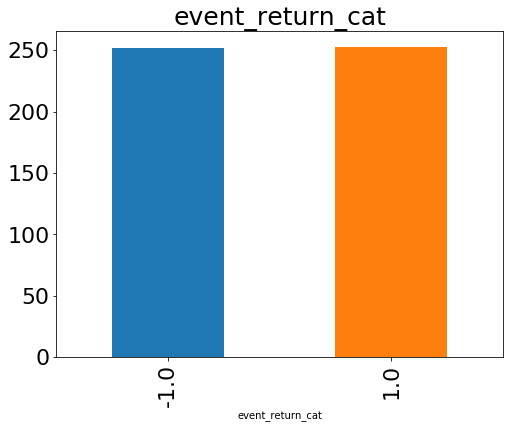

In [86]:
# Plot the number of classes: event_return
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('event_return_cat').event_return_cat.count().plot.bar(ylim=0, fontsize=22)
plt.title('event_return_cat', fontsize=25)
plt.show()

In [87]:
# Count the number of occurance for "-1" and "1" values in drift_90day_cat
df_esti_funda_norm.groupby('drift_80day_cat01').drift_80day_cat.count()

drift_80day_cat01
0    182
1    323
Name: drift_80day_cat, dtype: int64

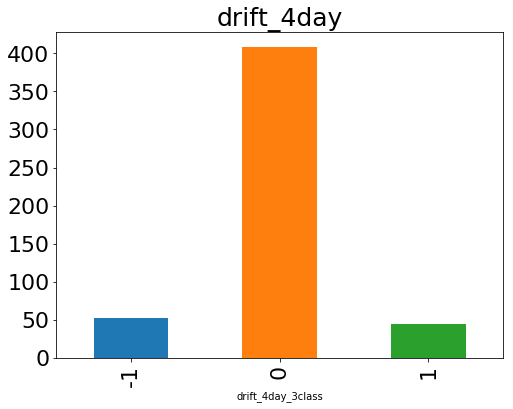

In [88]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_4day_3class').drift_4day_3class.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_4day', fontsize=25)
plt.show()

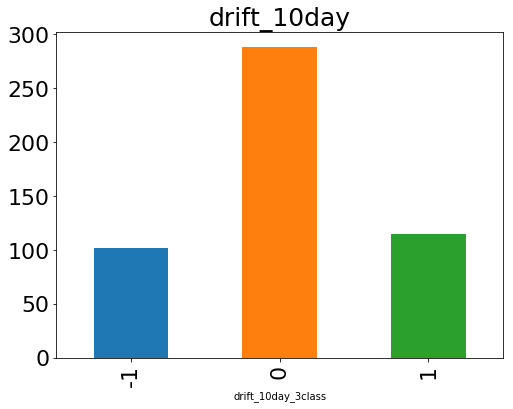

In [89]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_10day_3class').drift_10day_3class.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_10day', fontsize=25)
plt.show()

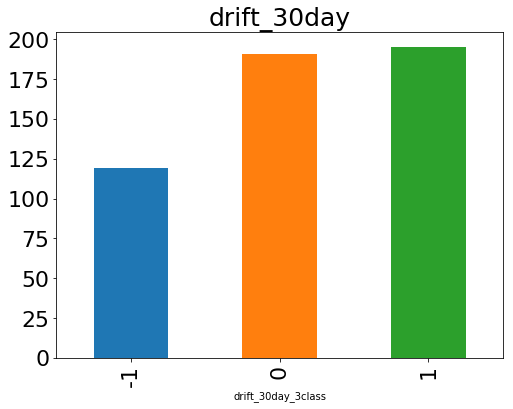

In [90]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_30day_3class').drift_30day_3class.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_30day', fontsize=25)
plt.show()

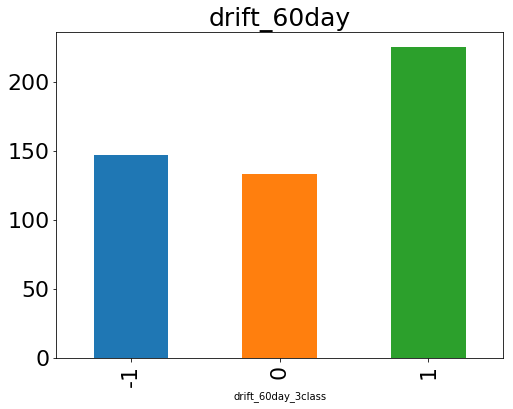

In [91]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_60day_3class').drift_60day_3class.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_60day', fontsize=25)
plt.show()

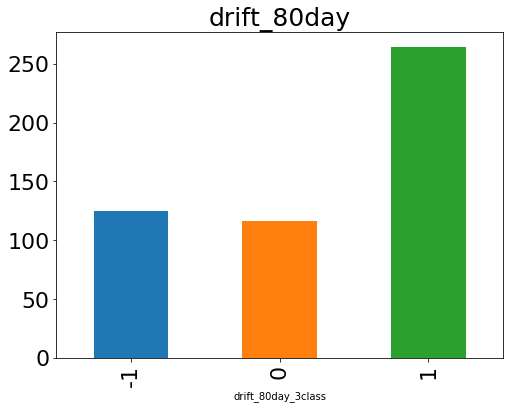

In [92]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_80day_3class').drift_80day_3class.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_80day', fontsize=25)
plt.show()

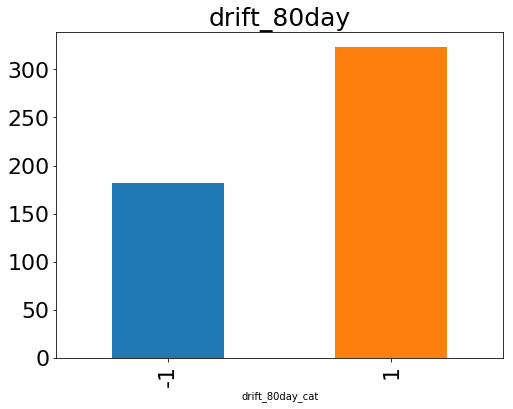

In [93]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_esti_funda_norm.groupby('drift_80day_cat').drift_80day_cat.count().plot.bar(ylim=0, fontsize=22)
plt.title('drift_80day', fontsize=25)
plt.show()

In [94]:
df_esti_funda_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 84 columns):
bull_bear_ratio                              505 non-null float64
bull_minus_bear                              505 non-null float64
sen                                          505 non-null float64
sum_msg_vol                                  505 non-null float64
weighted_sen                                 505 non-null float64
date                                         505 non-null datetime64[ns]
drift_10day                                  505 non-null float64
drift_10day_cat                              505 non-null float64
drift_30day                                  505 non-null float64
drift_30day_cat                              505 non-null float64
drift_4day                                   505 non-null float64
drift_4day_cat                               505 non-null float64
drift_60day                                  505 non-null float64
drift_60day_cat               

<div class="span5 alert alert-success">
Machine learning algorithms

</div>

#### Create One Hot Encoded labels for XGBoost:

In [95]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder

In [96]:
#Apply the OneHotEncoder
#ohe = OneHotEncoder(categories='auto')
#y1 = ohe.fit_transform(df_esti_funda_norm.drift_80day_cat01.values.reshape(-1,1)).toarray()

In [97]:
## Add the encoded target variables back to the original dataframe
#drift_80day01_encod = pd.DataFrame(y1, columns = ["80day_"+str(int(i)) for i in range(y1.shape[1])])

#df_encoded = pd.concat([df_esti_funda_norm, drift_80day01_encod], axis=1)

In [98]:
#label_encoder = LabelEncoder()
#y = df_esti_funda_norm.drift_80day_cat01
#label_encoder = label_encoder.fit(y)
#label_encoded_y = label_encoder.transform(y)

N.B. Tried using OneHotEncoded y for the XGBoost model below, however, the xgb.fit() does not take the OneHotEncoded y arrays, it takes 1D array for y only. Also tried just converting y using LabelEncoder, but the output array is exactly as the original y, i.e., 0 or 1. 

It seems that the OneHotEncoding is for the feature values only. 

### Split data into training and test sets

In [99]:
# Extract the first 80% of earlier dates into training set, and the rest 20% into test set.
train_perc = 0.8

# Reset index
df_esti_copy = df_esti_funda_norm.set_index('date')
df_esti_copy.sort_index(inplace=True);

In [100]:
df_esti_copy.index[-1]

Timestamp('2018-07-16 00:00:00')

In [101]:
# Date range of the data
date_range = df_esti_copy.index[-1] - df_esti_copy.index[0]
delta_days = int(date_range.days*train_perc)
train_stop_date = df_esti_copy.index[0] + timedelta(days=delta_days)

# Select training and test data according to dates
df_train = df_esti_copy[df_esti_copy.index < train_stop_date]
df_test = df_esti_copy[df_esti_copy.index >= train_stop_date]

In [102]:
df_test.index[0]

Timestamp('2017-06-29 00:00:00')

In [103]:
len(df_train)

375

In [104]:
len(df_test)

130

In [105]:
pd.DataFrame(df_train.columns)[40:85]

,0
40,ebit_last_q
41,equity_per_share_growth_last_q
42,financial_leverage_last_q
43,gross_margin_last_q
44,inventory_turnover_last_q
45,long_term_debt_equity_ratio_last_q
46,long_term_debt_total_capital_ratio_last_q
47,net_income_cont_ops_growth_last_q
48,operating_cash_flow_last_q
49,operating_income_last_q


In [106]:
## For predicting event_return:
# Create array for features: training and testing
non_features = ['symbol', 'time', 'drift_10day', 'drift_10day_cat', 'drift_30day', \
          'drift_30day_cat', 'drift_4day', 'drift_4day_cat', 'drift_60day', \
          'drift_60day_cat', 'drift_80day', 'event_return', \
          'event_return_cat', 'drift_80day_cat', 'ev_3class', 'drift_4day_3class', 'drift_10day_3class',\
          'drift_30day_3class', 'drift_60day_3class', 'drift_80day_3class', 'drift_80day_cat01']
                        
features = [c for c in df_train.columns if c not in non_features]

x_train = df_train[features].values
x_test = df_test[features].values

# To be used with TimeSeriesSplit later
x = np.concatenate((x_train,x_test), axis=0)

In [107]:
## For predicting after event drifts:
# Create array for features: training and testing
non_features_drift = ['symbol', 'time', 'drift_10day', 'drift_10day_cat', 'drift_30day', \
          'drift_30day_cat', 'drift_4day', 'drift_4day_cat', 'drift_60day', \
          'drift_60day_cat', 'drift_80day', \
          'drift_80day_cat', 'ev_3class', 'drift_4day_3class', 'drift_10day_3class',\
          'drift_30day_3class', 'drift_60day_3class', 'drift_80day_3class', 'drift_80day_cat01']                     
          
features_drift = [c for c in df_train.columns if c not in non_features_drift]

x_train_drift = df_train[features_drift].values
x_test_drift = df_test[features_drift].values

# To be used with TimeSeriesSplit later
x_drift = np.concatenate((x_train_drift,x_test_drift), axis=0)

In [108]:
## Create arrays for the target variables: training and testing
# For binary output predictions:
y_train_ev_return_cat = df_train['event_return_cat'].values
y_test_ev_return_cat = df_test['event_return_cat'].values
y_train_80day_cat = df_train['drift_80day_cat'].values
y_test_80day_cat = df_test['drift_80day_cat'].values
y_train_80day_cat01 = df_train['drift_80day_cat01'].values
y_test_80day_cat01 = df_test['drift_80day_cat01'].values

# For 3 output predictions:
y_train_ev_return_3class = df_train['ev_3class'].values
y_test_ev_return_3class = df_test['ev_3class'].values
y_train_4day_3class = df_train['drift_4day_3class'].values
y_test_4day_3class = df_test['drift_4day_3class'].values
y_train_10day_3class = df_train['drift_10day_3class'].values
y_test_10day_3class = df_test['drift_10day_3class'].values
y_train_60day_3class = df_train['drift_60day_3class'].values
y_test_60day_3class = df_test['drift_60day_3class'].values
y_train_80day_3class = df_train['drift_80day_3class'].values
y_test_80day_3class = df_test['drift_80day_3class'].values

# To be used with TimeSeriesSplit later
y_ev_return_cat = df['event_return_cat'].values

## Binary output prediction ("+1" and "-1" outputs only)

### Event Return

Perform hyperparameter tuning using RandomizedSearchCV

In [109]:
# Create the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=2)
my_cv = TimeSeriesSplit(n_splits=2).split(x)

__Logistic Regression__

In [110]:
# Logistic regression definition
logreg = LogisticRegression(solver='sag', max_iter=5000)

# Define the parameter grid to be searched from
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Hyperparameter tuning using RandomizedSearchCV
LR_cv = RandomizedSearchCV(logreg, param_grid, cv = 4, scoring = 'neg_log_loss', random_state = 7)

In [111]:
# Fit the model
LR_cv.fit(x_train, y_train_ev_return_cat)

# Use the optimised parameters to predict
y_pred_ev_return_cat_LR = LR_cv.predict(x_test)

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

N.B. The above warning message says "The max_iter was reached which means the coef_ did not converge", probably due to the non-linear nature and high dimensionality of the dataset. 

In [112]:
# Print optimised results from different estimators
print('Logistic regression:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_LR))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_LR))

Logistic regression:
[[35 31]
 [29 35]]
              precision    recall  f1-score   support

        -1.0       0.55      0.53      0.54        66
         1.0       0.53      0.55      0.54        64

   micro avg       0.54      0.54      0.54       130
   macro avg       0.54      0.54      0.54       130
weighted avg       0.54      0.54      0.54       130



In [113]:
# To see the estimated coefficients
# First need to fit the model with the optimised parameters found
#LR_cv.best_params_

In [114]:
#lr = LogisticRegression(C=1e-05, solver='sag', max_iter=5000)
#lr.fit(x_train, y_train_ev_return_cat)

#lr_features = pd.DataFrame(lr.coef_, columns=features).T

#lr_features.sort_values(by=0, inplace=True)

#fig = plt.figure(figsize=(20,14))
#lr_features.plot.bar()
#plt.show()

__Random Forest__

In [115]:
# Random Forest
#RF = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features='auto')
RF = RandomForestClassifier()

# 2. Define the parameter grid to be searched from
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# 3. Hyperparameter tuning using RandomizedSearchCV
RF_cv = RandomizedSearchCV(RF, random_grid, cv = 4, scoring = 'neg_log_loss', random_state = 7)

In [116]:
# Fit the model
RF_cv.fit(x_train, y_train_ev_return_cat);

# Use the optimised parameters to predict
y_pred_ev_return_cat_RF = RF_cv.predict(x_test)

print('Random Forest:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_RF))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_RF))
print('\n')

Random Forest:
[[32 34]
 [31 33]]
              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.50        66
         1.0       0.49      0.52      0.50        64

   micro avg       0.50      0.50      0.50       130
   macro avg       0.50      0.50      0.50       130
weighted avg       0.50      0.50      0.50       130





In [117]:
# To see the important features
# First need to fit the model with the optimised parameters:
RF_cv.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10}

In [118]:
RF_opt = RandomForestClassifier(n_estimators= 1200,
 min_samples_split= 10,
 min_samples_leaf= 4,
 max_features= 'sqrt',
 max_depth= 10)

RF_opt.fit(x_train, y_train_ev_return_cat);

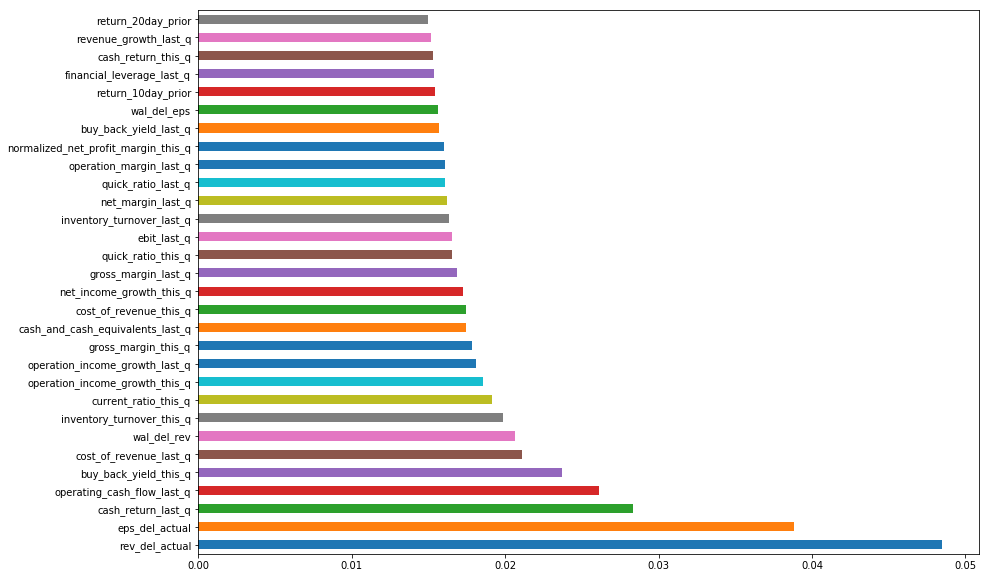

In [119]:
fig = plt.figure(figsize=(14,10))
(pd.Series(RF_opt.feature_importances_, index=features)
   .nlargest(30)
   .plot(kind='barh')) 
plt.show()

N.B. Surprisingly, the StockTwit data did not seem important, only the sentiment 'sen' made it to the list, at about 20th position. 

__AdaBoost__

AdaBoost performs by boosting the performace of weak learners such as single-level decision trees. By iteratively assigning heavier weights to the previously incorrectly classified data points, the subsequent classifiers focus more on difficult cases, thus improving performance gradually. 

In [120]:
# Create Adaboost-decision tree classifer object
Ada_clf = AdaBoostClassifier()

# Define the parameter grid to be searched from
para_ada = {
 'n_estimators': [50, 100, 200, 500, 1000, 2000],
 'learning_rate' : [0.01, 0.05, 0.1, 0.3, 1]}

# Hyperparameter tuning using RandomizedSearchCV
Ada_cv = RandomizedSearchCV(Ada_clf, para_ada, cv = 4, n_iter = 20, random_state = 7)

In [121]:
# Fit the model
Ada_cv.fit(x_train, y_train_ev_return_cat);

# View the best parameters found
print(Ada_cv.best_params_)

# Use the optimised parameters to predict
y_pred_ev_return_cat_Ada = Ada_cv.predict(x_test)

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 100, 'learning_rate': 0.1}


In [122]:
# Re-define the parameter grid to be searched from, based on the best parameters found above
para_ada = {
 'n_estimators': [20, 50, 80, 100, 200],
 'learning_rate' : [0.5, 0.8, 1, 1.2, 2]}

# Hyperparameter tuning using RandomizedSearchCV
Ada_cv = RandomizedSearchCV(Ada_clf, para_ada, cv = 4, n_iter = 20, random_state = 7)

# Fit the model
Ada_cv.fit(x_train, y_train_ev_return_cat);

# View the best parameters found
print(Ada_cv.best_params_)

# Use the optimised parameters to predict
y_pred_ev_return_cat_Ada = Ada_cv.predict(x_test)

{'n_estimators': 50, 'learning_rate': 0.8}


/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__Support Vector Machine (SVM)__

In [123]:
# Create Adaboost-decision tree classifer object
SVM_clf = SVC()

# Define the parameter grid to be searched from
para_SVM = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 8],
              'gamma':[0.5, 0.1, 0.01, 0.001, 0.0001]}

# Hyperparameter tuning using RandomizedSearchCV
SVM_cv = GridSearchCV(SVM_clf, para_SVM, cv = 4)

In [124]:
# Fit the model
SVM_cv.fit(x_train, y_train_ev_return_cat);

# View the best parameters found
print(SVM_cv.best_params_)

# Use the optimised parameters to predict
y_pred_ev_return_cat_SVM = SVM_cv.predict(x_test)

{'C': 1, 'gamma': 0.01}


/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__XGBoost__

There are a few useful parameters to set (https://xgboost.readthedocs.io/en/latest/parameter.html):
Objective: Specify the learning task and the corresponding learning objective. In our case, we will use 'multi:softmax' or 'multi:softprob'.
* multi:softmax: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
* multi:softprob: same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.

In [125]:
# Instantiate the XGBClassifier: xg
xg = xgb.XGBClassifier(objective='multi:softmax', num_class=2, n_estimators=10, seed=123)

In [126]:
# Fit the model
xg.fit(x_train, y_train_ev_return_cat);

# Use the optimised parameters to predict
y_pred_ev_return_cat_xg = xg.predict(x_test)

__Compare results from different models:__

In [127]:
# Print optimised results from different estimators
print('Logistic regression:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_LR))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_LR))

print('Random Forest:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_RF))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_RF))

print('AdaBoost:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_Ada))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_Ada))

print('SVM:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_SVM))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_SVM))

print('XGBoost:')
print(confusion_matrix(y_test_ev_return_cat, y_pred_ev_return_cat_xg))
print(classification_report(y_test_ev_return_cat, y_pred_ev_return_cat_xg))

Logistic regression:
[[35 31]
 [29 35]]
              precision    recall  f1-score   support

        -1.0       0.55      0.53      0.54        66
         1.0       0.53      0.55      0.54        64

   micro avg       0.54      0.54      0.54       130
   macro avg       0.54      0.54      0.54       130
weighted avg       0.54      0.54      0.54       130

Random Forest:
[[32 34]
 [31 33]]
              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.50        66
         1.0       0.49      0.52      0.50        64

   micro avg       0.50      0.50      0.50       130
   macro avg       0.50      0.50      0.50       130
weighted avg       0.50      0.50      0.50       130

AdaBoost:
[[34 32]
 [31 33]]
              precision    recall  f1-score   support

        -1.0       0.52      0.52      0.52        66
         1.0       0.51      0.52      0.51        64

   micro avg       0.52      0.52      0.52       130
   macro avg       0.52  

### 80-day drift

### Dealing with imbalanced classes

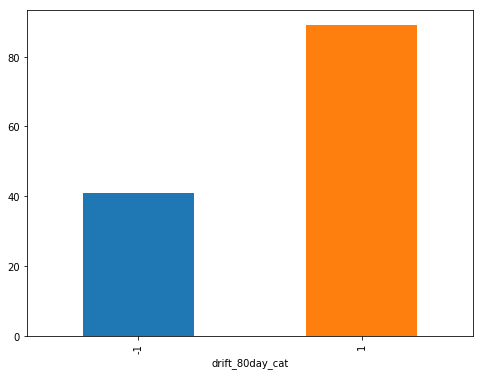

In [128]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
#df_test.groupby('drift_80day_3class').drift_80day_3class.count().plot.bar(ylim=0)
df_test.groupby('drift_80day_cat').drift_80day_cat.count().plot.bar(ylim=0)
plt.show()

__Logistic Regression__

In [129]:
# Define the default model
LR_0 = LogisticRegression(solver='sag', max_iter=5000, random_state=7)

# Fit the model
LR_0.fit(x_train_drift, y_train_80day_cat);

# Use the optimised parameters to predict
y_pred_80day_LR0 = LR_0.predict(x_test_drift)

#----------------
# The modified model
LR_1 = LogisticRegression(solver='sag', max_iter=5000, class_weight = {-1:0.51, 1:0.49}, random_state=7)

# Fit the model
LR_1.fit(x_train_drift, y_train_80day_cat);

# Use the optimised parameters to predict
y_pred_80day_LR1 = LR_1.predict(x_test_drift)

print('The default model prediction:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_LR0))
print(classification_report(y_test_80day_cat, y_pred_80day_LR0))

print('\nThe modified model prediction:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_LR1))
print(classification_report(y_test_80day_cat, y_pred_80day_LR1))

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The default model prediction:
[[13 28]
 [24 65]]
              precision    recall  f1-score   support

          -1       0.35      0.32      0.33        41
           1       0.70      0.73      0.71        89

   micro avg       0.60      0.60      0.60       130
   macro avg       0.53      0.52      0.52       130
weighted avg       0.59      0.60      0.59       130


The modified model prediction:
[[15 26]
 [26 63]]
              precision    recall  f1-score   support

          -1       0.37      0.37      0.37        41
           1       0.71      0.71      0.71        89

   micro avg       0.60      0.60      0.60       130
   macro avg       0.54      0.54      0.54       130
weighted avg       0.60      0.60      0.60       130



/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


__Rank top 10 stocks:__

__Random Forest__

In [130]:
# Define the default model
RF_0 = RandomForestClassifier(random_state=7)

# Fit the model
RF_0.fit(x_train_drift, y_train_80day_cat);

# Use the optimised parameters to predict
y_pred_80day_RF0 = RF_0.predict(x_test_drift)

#----------------
# The modified model
RF_1 = RandomForestClassifier(class_weight = {-1:0.6, 1:0.4}, random_state=7)

# Fit the model
RF_1.fit(x_train_drift, y_train_80day_cat);

# Use the optimised parameters to predict
y_pred_80day_RF1 = RF_1.predict(x_test_drift)

print('The default model prediction:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_RF0))
print(classification_report(y_test_80day_cat, y_pred_80day_RF0))

print('\nThe modified model prediction:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_RF1))
print(classification_report(y_test_80day_cat, y_pred_80day_RF1))
print('class_weight = ' + str({-1:0.6, 1:0.4}))

The default model prediction:
[[10 31]
 [34 55]]
              precision    recall  f1-score   support

          -1       0.23      0.24      0.24        41
           1       0.64      0.62      0.63        89

   micro avg       0.50      0.50      0.50       130
   macro avg       0.43      0.43      0.43       130
weighted avg       0.51      0.50      0.50       130


The modified model prediction:
[[16 25]
 [30 59]]
              precision    recall  f1-score   support

          -1       0.35      0.39      0.37        41
           1       0.70      0.66      0.68        89

   micro avg       0.58      0.58      0.58       130
   macro avg       0.53      0.53      0.52       130
weighted avg       0.59      0.58      0.58       130

class_weight = {-1: 0.6, 1: 0.4}


/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


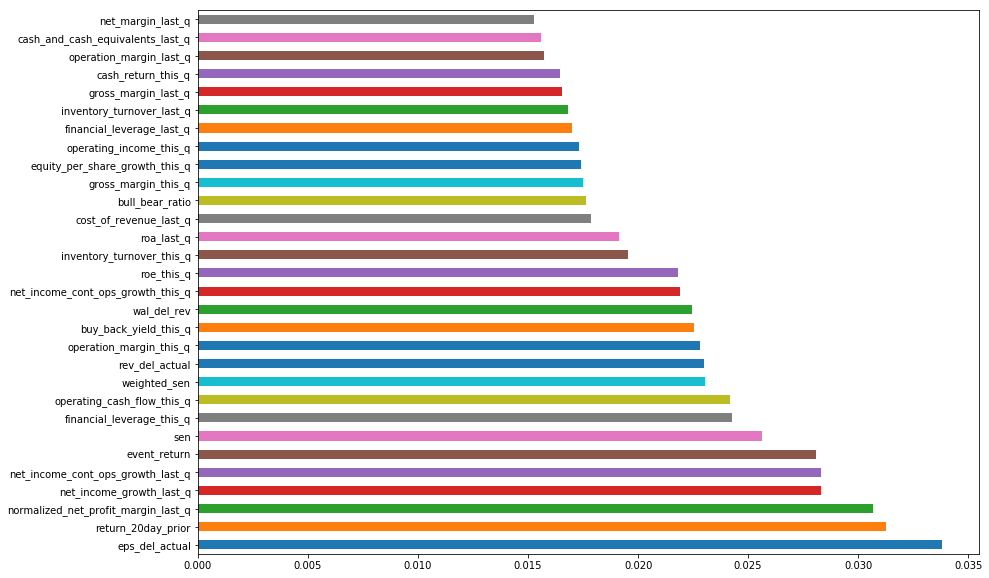

In [131]:
# To see the important features
fig = plt.figure(figsize=(14,10))
(pd.Series(RF_1.feature_importances_, index=features_drift)
   .nlargest(30)
   .plot(kind='barh')) 
plt.show()

In contrast to the event_return predicted above, this time 'wal_del_rev', the difference in revenue predictions between Estimize and Wall Street, is the most important feature, followed by some fundamental metrics and the reaction of the earnings report (event_return), and sum of message volume (sum_msg_vol) reported by StockTwit prior to the news date. 

__Rank top 10 stocks with '+1' being predicted:__

Next, we will perform hyperparameters tuning (including class_weight) using RandomizedSearchCV, evaluated by log_loss. 

In [132]:
from numpy import *

In [133]:
# Random Forest
#RF = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features='auto')
RF = RandomForestClassifier()

# 2. Define the parameter grid to be searched from
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Different weights assigned to the imbalanced classes
class_weight = [{-1:0.5, 1:0.5}, {-1:0.6, 1:0.4}, {-1:0.7, 1:0.4}, {-1:0.8, 1:0.4}]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}

# 3. Hyperparameter tuning using RandomizedSearchCV
RF_80_cat_cv = RandomizedSearchCV(RF, random_grid, cv = 4, scoring = 'neg_log_loss', random_state = random.seed(123))
#RF_80_cat_cv = RandomizedSearchCV(RF, random_grid, cv = 4, random_state = 7)
# If not using scoring = 'neg_log_loss', which penalises the confident but wrong predictions, the top 10 stocks ranked
# below would produce only 8% return rather than 13%. 

In [152]:
# Fit the model
RF_80_cat_cv.fit(x_train_drift, y_train_80day_cat)

# Use the optimised parameters to predict
y_pred_80day_RF_cv = RF_80_cat_cv.predict(x_test_drift)

print(confusion_matrix(y_test_80day_cat, y_pred_80day_RF_cv))
print(classification_report(y_test_80day_cat, y_pred_80day_RF_cv))

[[ 2 39]
 [14 75]]
              precision    recall  f1-score   support

          -1       0.12      0.05      0.07        41
           1       0.66      0.84      0.74        89

   micro avg       0.59      0.59      0.59       130
   macro avg       0.39      0.45      0.40       130
weighted avg       0.49      0.59      0.53       130



In [153]:
RF_80_cat_cv.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': {-1: 0.8, 1: 0.4}}

__Rank top 10 stocks with '+1' being predicted:__

In [154]:
df_test_drift_80day = pd.DataFrame(df_test['drift_80day'].values)

# View the predicted probabilities for the Random Forest model 
results_rf1 = pd.DataFrame([y_test_80day_cat, y_pred_80day_RF_cv]).T
results_rf2 = pd.DataFrame(RF_80_cat_cv.predict_proba(x_test_drift))
results_rf = pd.concat([df_test_drift_80day, results_rf1, results_rf2], axis=1)

results_rf.columns = ['actual return', 'correct label', 'predicted label',\
                                'proba_predicted_neg', 'proba_predicted_pos']

max_prob = []
for i, row in results_rf.iterrows():
    max_prob.append(np.max([row.proba_predicted_neg, row.proba_predicted_pos]))
    
results_rf = results_rf.assign(max_prob=max_prob) 

# Extract rows with predicted label == 1:
results_rf_pos = results_rf[results_rf['predicted label'] == 1]

# Sort according to max_prob
res_rf_sorted = results_rf_pos.sort_values(by='max_prob', ascending=0)
top_predictions = res_rf_sorted.iloc[0:10,:]

sum_return_rf = top_predictions['actual return'].sum()
mean_return_rf = top_predictions['actual return'].mean()
sum_all_return = res_rf_sorted['actual return'].mean()

print('Mean of actual returns if buying all stocks in the test set: ' +str(sum_all_return))
print('Sum of actual returns if buying top 10 predicted stocks: '+str(sum_return_rf))
print('Mean of actual returns if buying top 10 predicted stocks: '+str(mean_return_rf))                       

Mean of actual returns if buying all stocks in the test set: 5.348833526315792
Sum of actual returns if buying top 10 predicted stocks: 86.725947
Mean of actual returns if buying top 10 predicted stocks: 8.672594700000001


In [137]:
res_rf_sorted.head(20)

,actual return,correct label,predicted label,proba_predicted_neg,proba_predicted_pos,max_prob
0,-9.012043,-1,1,0.190110,0.809890,0.809890
66,24.516541,1,1,0.219398,0.780602,0.780602
27,12.010138,1,1,0.242932,0.757068,0.757068
127,11.858581,1,1,0.247888,0.752112,0.752112
68,-15.830789,-1,1,0.251978,0.748022,0.748022
96,49.365910,1,1,0.252608,0.747392,0.747392
120,13.580670,1,1,0.253423,0.746577,0.746577
16,1.961369,1,1,0.253962,0.746038,0.746038
59,32.395644,1,1,0.257302,0.742698,0.742698
54,10.217996,1,1,0.266713,0.733287,0.733287


__AdaBoost__

In [173]:
# Create Adaboost-decision tree classifer object
Ada_clf = AdaBoostClassifier()

# Define the parameter grid to be searched from
para_ada = {
 'n_estimators': [50, 100, 200, 500, 1000, 2000],
 'learning_rate' : [0.01, 0.05, 0.1, 0.3, 1]}



# AdaBoostClassifier does not have class_weight parameter, as it is an ensemble method, which already takes into 
# the effect of imbalanced classes. 
# Hyperparameter tuning using RandomizedSearchCV
Ada_cv = RandomizedSearchCV(Ada_clf, para_ada, cv = 4, scoring = 'neg_log_loss', n_iter = 20, random_state = 10)
#Ada_cv = RandomizedSearchCV(Ada_clf, para_ada, cv = 4, n_iter = 20, random_state = 12)
# Without using scoring = 'neg_log_loss', the returns calculated for the top 10 stocks predicted below is only 
# 5.9% rather than 11.4%.

In [174]:
Ada_cv.fit(x_train_drift, y_train_80day_cat);

# View the best parameters found
#print(Ada_cv.best_params_)

# Use the optimised parameters to predict
y_pred_80day_cat_Ada = Ada_cv.predict(x_test_drift)

In [175]:
print(confusion_matrix(y_test_80day_cat, y_pred_80day_cat_Ada))
print(classification_report(y_test_80day_cat, y_pred_80day_cat_Ada))

[[ 0 41]
 [ 1 88]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        41
           1       0.68      0.99      0.81        89

   micro avg       0.68      0.68      0.68       130
   macro avg       0.34      0.49      0.40       130
weighted avg       0.47      0.68      0.55       130



In [195]:
df_test_drift_80day = pd.DataFrame(df_test['drift_80day'].values)

# View the predicted probabilities for the Random Forest model 
results_ada1 = pd.DataFrame([y_test_80day_cat, y_pred_80day_cat_Ada]).T
results_ada2 = pd.DataFrame(Ada_cv.predict_proba(x_test_drift))
results_ada = pd.concat([df_test_drift_80day, results_ada1, results_ada2], axis=1)

results_ada.columns = ['actual return', 'correct label', 'predicted label',\
                                'proba_predicted_neg', 'proba_predicted_pos']

max_prob = []
for i, row in results_ada.iterrows():
    max_prob.append(np.max([row.proba_predicted_neg, row.proba_predicted_pos]))
    
results_ada = results_ada.assign(max_prob=max_prob) 

# Extract rows with predicted label == 1:
results_ada_pos = results_ada[results_ada['predicted label'] == 1]

# Sort according to max_prob
res_ada_sorted = results_ada_pos.sort_values(by='max_prob', ascending=0)
top_predictions = res_ada_sorted.iloc[0:30,:]

sum_return_ada = top_predictions['actual return'].sum()
mean_return_ada = top_predictions['actual return'].mean()
mean_all_return = results_ada['actual return'].mean()
#mean_all_return = df_test_drift_80day.mean()

print('Mean of actual returns if buying all stocks in the test set: ' +str(mean_all_return))
print('Sum of actual returns if buying top 10 predicted stocks: '+str(sum_return_ada))
print('Mean of actual returns if buying top 10 predicted stocks: '+str(mean_return_ada))                       

Mean of actual returns if buying all stocks in the test set: 6.019855615384617
Sum of actual returns if buying top 10 predicted stocks: 214.074635
Mean of actual returns if buying top 10 predicted stocks: 7.135821166666667


In [196]:
res_ada_sorted.head(30)

,actual return,correct label,predicted label,proba_predicted_neg,proba_predicted_pos,max_prob
50,25.062062,1,1,0.343687,0.656313,0.656313
108,16.858161,1,1,0.349738,0.650262,0.650262
9,-4.139875,-1,1,0.349738,0.650262,0.650262
68,-15.830789,-1,1,0.349738,0.650262,0.650262
120,13.580670,1,1,0.370626,0.629374,0.629374
127,11.858581,1,1,0.370626,0.629374,0.629374
124,16.591486,1,1,0.370626,0.629374,0.629374
99,-2.759436,-1,1,0.370626,0.629374,0.629374
101,3.723136,1,1,0.373509,0.626491,0.626491
96,49.365910,1,1,0.373858,0.626142,0.626142


__SVM__

In [143]:
# Create SVM classifer object
SVM_clf = SVC(probability=True)

# Define the parameter grid to be searched from
para_SVM = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 8],
              'gamma':[0.5, 0.1, 0.01, 0.001, 0.0001],
            'class_weight': [{-1:0.4, 1:0.6}, {-1:0.5, 1:0.5}, {-1:0.6, 1:0.4}, {-1:0.7, 1:0.4}, {-1:0.8, 1:0.4}]
           }

# Hyperparameter tuning using RandomizedSearchCV
SVM_cv = RandomizedSearchCV(SVM_clf, para_SVM, cv = 4, n_iter = 20, random_state = 7)

In [183]:
# Fit the model
SVM_clf.fit(x_train_drift, y_train_80day_cat);

# View the best parameters found
#print(SVM_cv.best_params_)

# Use the optimised parameters to predict
y_pred_80day_SVM = SVM_clf.predict(x_test_drift)

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [184]:
print(confusion_matrix(y_test_80day_cat, y_pred_80day_SVM))
print(classification_report(y_test_80day_cat, y_pred_80day_SVM))

[[ 4 37]
 [14 75]]
              precision    recall  f1-score   support

          -1       0.22      0.10      0.14        41
           1       0.67      0.84      0.75        89

   micro avg       0.61      0.61      0.61       130
   macro avg       0.45      0.47      0.44       130
weighted avg       0.53      0.61      0.55       130



In [185]:
df_test_drift_80day = pd.DataFrame(df_test['drift_80day'].values)

# View the predicted probabilities for the Random Forest model 
results_svm1 = pd.DataFrame([y_test_80day_cat, y_pred_80day_SVM]).T
results_svm2 = pd.DataFrame(SVM_clf.predict_proba(x_test_drift))
results_svm = pd.concat([df_test_drift_80day, results_svm1, results_svm2], axis=1)

results_svm.columns = ['actual return', 'correct label', 'predicted label',\
                                'proba_predicted_neg', 'proba_predicted_pos']

max_prob = []
for i, row in results_svm.iterrows():
    max_prob.append(np.max([row.proba_predicted_neg, row.proba_predicted_pos]))
    
results_svm = results_svm.assign(max_prob=max_prob) 

# Extract rows with predicted label == 1:
results_svm_pos = results_svm[results_svm['predicted label'] == 1]

# Sort according to max_prob
res_svm_sorted = results_svm_pos.sort_values(by='max_prob', ascending=0)
top_predictions = res_svm_sorted.iloc[0:10,:]

sum_return_svm = top_predictions['actual return'].sum()
mean_return_svm = top_predictions['actual return'].mean()
mean_all_return = results_svm['actual return'].mean()

print('Mean of actual returns if buying all stocks in the test set: ' +str(mean_all_return))
print('Sum of actual returns if buying top 10 predicted stocks: '+str(sum_return_svm))
print('Mean of actual returns if buying top 10 predicted stocks: '+str(mean_return_svm))                       

Mean of actual returns if buying all stocks in the test set: 6.019855615384617
Sum of actual returns if buying top 10 predicted stocks: 31.400075000000005
Mean of actual returns if buying top 10 predicted stocks: 3.1400075


In [159]:
res_svm_sorted.head(10)

,actual return,correct label,predicted label,proba_predicted_neg,proba_predicted_pos,max_prob
11,-3.658537,-1,1,0.155075,0.844925,0.844925
127,11.858581,1,1,0.196311,0.803689,0.803689
115,8.939310,1,1,0.212437,0.787563,0.787563
106,19.052541,1,1,0.227043,0.772957,0.772957
101,3.723136,1,1,0.231493,0.768507,0.768507
87,-2.747756,-1,1,0.234693,0.765307,0.765307
1,7.825945,1,1,0.236444,0.763556,0.763556
10,-2.058433,-1,1,0.249085,0.750915,0.750915
81,3.437052,1,1,0.251192,0.748808,0.748808
112,-12.237798,-1,1,0.252911,0.747089,0.747089


__XGBoost__

In [147]:
# Instantiate the XGBClassifier: xg
xg2 = xgb.XGBClassifier(objective='multi:softmax', num_class=2, n_estimators=10, seed=123)

In [148]:
# Fit the model
xg2.fit(x_train_drift, y_train_80day_cat);

# Use the optimised parameters to predict
y_pred_80day_xg = xg2.predict(x_test_drift)

In [149]:
print(confusion_matrix(y_test_80day_cat, y_pred_80day_xg))
print(classification_report(y_test_80day_cat, y_pred_80day_xg))

[[ 5 36]
 [20 69]]
              precision    recall  f1-score   support

          -1       0.20      0.12      0.15        41
           1       0.66      0.78      0.71        89

   micro avg       0.57      0.57      0.57       130
   macro avg       0.43      0.45      0.43       130
weighted avg       0.51      0.57      0.53       130



__Rank top 10 stocks:__

In [150]:
df_test_drift_80day = pd.DataFrame(df_test['drift_80day'].values)

# View the predicted probabilities for the XGBoost model 
results_xg1 = pd.DataFrame([y_test_80day_cat, y_pred_80day_xg]).T
results_xg2 = pd.DataFrame(xg2.predict_proba(x_test_drift))
results_xg = pd.concat([df_test_drift_80day, results_xg1, results_xg2], axis=1)

results_xg.columns = ['actual return', 'correct label', 'predicted label',\
                                'proba_predicted_0', 'proba_predicted_1']

max_prob = []
for i, row in results_xg.iterrows():
    max_prob.append(np.max([row.proba_predicted_0, row.proba_predicted_1]))
    
results_xg = results_xg.assign(max_prob=max_prob) 

# Extract rows with predicted label == 1:
results_xg_pos = results_xg[results_xg['predicted label'] == 1]

# Sort according to max_prob
res_xg_sorted = results_xg_pos.sort_values(by='max_prob', ascending=0)
top_predictions = res_xg_sorted.iloc[0:10,:]

sum_return_xg = top_predictions['actual return'].sum()
mean_return_xg = top_predictions['actual return'].mean()
mean_all_return = results_xg['actual return'].mean()

print('Mean of actual returns if buying all stocks in the test set: ' +str(mean_all_return))
print('Sum of actual returns if buying top 10 predicted stocks: '+str(sum_return_xg))
print('Mean of actual returns if buying top 10 predicted stocks: '+str(mean_return_xg))                       

Mean of actual returns if buying all stocks in the test set: 6.019855615384617
Sum of actual returns if buying top 10 predicted stocks: -4.546368
Mean of actual returns if buying top 10 predicted stocks: -0.4546368


In [151]:
res_xg_sorted.head(10)

,actual return,correct label,predicted label,proba_predicted_0,proba_predicted_1,max_prob
0,-9.012043,-1,1,0.0,1.0,1.0
61,0.149799,1,1,0.0,1.0,1.0
92,6.298685,1,1,0.0,1.0,1.0
91,3.548402,1,1,0.0,1.0,1.0
90,2.838428,1,1,0.0,1.0,1.0
89,6.715279,1,1,0.0,1.0,1.0
88,-0.296120,-1,1,0.0,1.0,1.0
87,-2.747756,-1,1,0.0,1.0,1.0
86,-6.752259,-1,1,0.0,1.0,1.0
85,-5.288783,-1,1,0.0,1.0,1.0


N.B. Not sure why the XGBoost gave such high probabilities for the predicted classes, e.g., 0.99, in contrast to other models which only predicted 0.7 or so. 

In [134]:
# Print optimised results from different estimators
print('Logistic regression:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_LR1))
print(classification_report(y_test_80day_cat, y_pred_80day_LR1))

print('Random Forest:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_RF_cv))
print(classification_report(y_test_80day_cat, y_pred_80day_RF_cv))

print('AdaBoost:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_cat_Ada))
print(classification_report(y_test_80day_cat, y_pred_80day_cat_Ada))

print('SVM:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_SVM))
print(classification_report(y_test_80day_cat, y_pred_80day_SVM))

print('XGBoost:')
print(confusion_matrix(y_test_80day_cat, y_pred_80day_xg))
print(classification_report(y_test_80day_cat, y_pred_80day_xg))

Logistic regression:
[[15 26]
 [26 63]]
              precision    recall  f1-score   support

          -1       0.37      0.37      0.37        41
           1       0.71      0.71      0.71        89

   micro avg       0.60      0.60      0.60       130
   macro avg       0.54      0.54      0.54       130
weighted avg       0.60      0.60      0.60       130

Random Forest:
[[ 3 38]
 [10 79]]
              precision    recall  f1-score   support

          -1       0.23      0.07      0.11        41
           1       0.68      0.89      0.77        89

   micro avg       0.63      0.63      0.63       130
   macro avg       0.45      0.48      0.44       130
weighted avg       0.54      0.63      0.56       130

AdaBoost:
[[ 0 41]
 [ 1 88]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        41
           1       0.68      0.99      0.81        89

   micro avg       0.68      0.68      0.68       130
   macro avg       0.34  

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__Hyperparameters tuning for XGBoost__

In [186]:
def modelfit(alg, x_train, y_train, x_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """Define a custom function to create XGBoost models and perform cross-validation"""
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        
        # Cross-validation with given parameters:
        #cvresult = xgb.cv(xgb_param, xgtrain)       
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
                                    
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='mlogloss')
        
    # Predict training set:
    #dtrain_predictions = alg.predict(x)
    #dtrain_predprob = alg.predict_proba(x)[:,1]
    
    # Predict test set:
    y_pred = alg.predict(x_test)
        
    #Print model report:
    #print(\nModel Report")
    #print(Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    
    return y_pred

In [187]:
xgtrain = xgb.DMatrix(x_train, label=y_train_80day_cat01)

In [188]:
# Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
xgb1 = xgb.XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1,\
                         gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'multi:softprob',\
                         num_class=2, nthread=4, scale_pos_weight=1, seed=27, eval_metric = 'mlogloss')

y_pred_80day_cat01_xg0 = modelfit(xgb1, x_train_drift, y_train_80day_cat01, x_test_drift, y_test_80day_cat01)

In [189]:
print(confusion_matrix(y_test_80day_cat01, y_pred_80day_cat01_xg0))
print(classification_report(y_test_80day_cat01, y_pred_80day_cat01_xg0))

[[ 8 33]
 [15 74]]
              precision    recall  f1-score   support

           0       0.35      0.20      0.25        41
           1       0.69      0.83      0.76        89

   micro avg       0.63      0.63      0.63       130
   macro avg       0.52      0.51      0.50       130
weighted avg       0.58      0.63      0.60       130



In [190]:
# Step 2: Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

search1 = RandomizedSearchCV(xgb.XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,\
                                               min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,\
                                               nthread=4, scale_pos_weight=1, seed=27,\
                                               ),\
                             param_distributions=param_test1, scoring='neg_log_loss', cv=4,\
                             random_state = random.seed(1234))                          

In [191]:
search1.fit(x_train_drift, y_train_80day_cat01)
search1.best_params_, search1.best_score_

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'min_child_weight': 5, 'max_depth': 5}, -0.9551667853618662)

N.B. A negative log-loss is obtained. The closer the (absolute) number gets to 1, the better the score. 

In [179]:
y_pred_search1 = search1.predict(x_test_drift)

print(confusion_matrix(y_test_80day_cat01, y_pred_search1))
print(classification_report(y_test_80day_cat01, y_pred_search1))

[[ 7 34]
 [24 65]]
              precision    recall  f1-score   support

           0       0.23      0.17      0.19        41
           1       0.66      0.73      0.69        89

   micro avg       0.55      0.55      0.55       130
   macro avg       0.44      0.45      0.44       130
weighted avg       0.52      0.55      0.53       130



__Rank top 10 stocks__

In [180]:
df_test_drift_80day = pd.DataFrame(df_test['drift_80day'].values)

# View the predicted probabilities for the XGBoost model 
results_xg1 = pd.DataFrame([y_test_80day_cat01, y_pred_search1]).T
results_xg2 = pd.DataFrame(search1.predict_proba(x_test_drift))
results_xg = pd.concat([df_test_drift_80day, results_xg1, results_xg2], axis=1)

results_xg.columns = ['actual return', 'correct label', 'predicted label',\
                                'proba_predicted_0', 'proba_predicted_1']

max_prob = []
for i, row in results_xg.iterrows():
    max_prob.append(np.max([row.proba_predicted_0, row.proba_predicted_1]))
    
results_xg = results_xg.assign(max_prob=max_prob) 

# Extract rows with predicted label == 1:
results_xg_pos = results_xg[results_xg['predicted label'] == 1]

# Sort according to max_prob
res_xg_sorted = results_xg_pos.sort_values(by='max_prob', ascending=0)
top_predictions = res_xg_sorted.iloc[0:10,:]

sum_return_xg = top_predictions['actual return'].sum()
mean_return_xg = top_predictions['actual return'].mean()
sum_all_return = res_xg_sorted['actual return'].mean()

print('Mean of actual returns if buying all stocks in the test set: ' +str(sum_all_return))
print('Sum of actual returns if buying top 10 predicted stocks: '+str(sum_return_xg))
print('Mean of actual returns if buying top 10 predicted stocks: '+str(mean_return_xg))                       

Mean of actual returns if buying all stocks in the test set: 5.422593141414142
Sum of actual returns if buying top 10 predicted stocks: 37.692298
Mean of actual returns if buying top 10 predicted stocks: 3.7692298


In [181]:
res_xg_sorted.head(10)

,actual return,correct label,predicted label,proba_predicted_0,proba_predicted_1,max_prob
66,24.516541,1,1,0.002974,0.997026,0.997026
128,4.697953,1,1,0.003381,0.996619,0.996619
0,-9.012043,0,1,0.004632,0.995368,0.995368
29,13.006122,1,1,0.009573,0.990427,0.990427
72,5.321352,1,1,0.010218,0.989782,0.989782
92,6.298685,1,1,0.010439,0.989561,0.989561
112,-12.237798,0,1,0.011919,0.988081,0.988081
23,-0.569614,0,1,0.012310,0.987690,0.987690
97,21.501889,1,1,0.013146,0.986854,0.986854
68,-15.830789,0,1,0.013699,0.986301,0.986301


## 3 output prediction (+1, 0 and -1 outputs)

### 80-day drift

### Dealing with imbalanced classes

As shown below, class "1" is the majority class. The following is a comparison of a default model and a modified model with class_weight adjusted. The class_weight penalizes mistakes in samples of class[i] with class_weight[i] instead of 1. So higher class-weight means one wants to put more emphasis on a class.

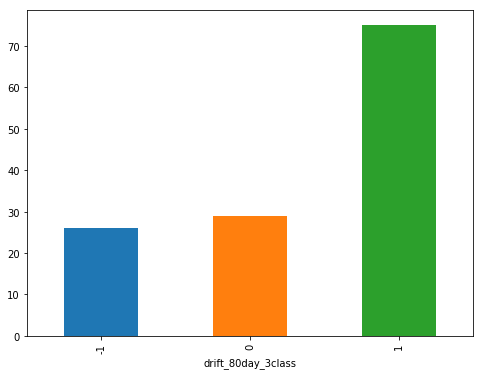

In [196]:
# Plot the number of classes: drift-80days
fig = plt.figure(figsize=(8,6))
df_test.groupby('drift_80day_3class').drift_80day_3class.count().plot.bar(ylim=0)
plt.show()

__Logistic Regression__

In [197]:
# Define the default model
LR_0 = LogisticRegression(solver='sag', max_iter=5000, random_state=7, multi_class='multinomial')

# Fit the model
LR_0.fit(x_train_drift, y_train_80day_3class);

# Use the optimised parameters to predict
y_pred_80day_LR0 = LR_0.predict(x_test_drift)

#----------------
# The modified model
LR_1 = LogisticRegression(solver='sag', max_iter=5000, class_weight = {-1:2, 0:2, 1:1}, random_state=7, \
                          multi_class='multinomial')

# Fit the model
LR_1.fit(x_train_drift, y_train_80day_3class);

# Use the optimised parameters to predict
y_pred_80day_LR1 = LR_1.predict(x_test_drift)

print('The default model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_LR0))
print(classification_report(y_test_80day_3class, y_pred_80day_LR0))

print('\nThe modified model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_LR1))
print(classification_report(y_test_80day_3class, y_pred_80day_LR1))

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The default model prediction:
[[ 4  4 18]
 [13  1 15]
 [18 10 47]]
              precision    recall  f1-score   support

          -1       0.11      0.15      0.13        26
           0       0.07      0.03      0.05        29
           1       0.59      0.63      0.61        75

   micro avg       0.40      0.40      0.40       130
   macro avg       0.26      0.27      0.26       130
weighted avg       0.38      0.40      0.39       130


The modified model prediction:
[[ 9  7 10]
 [20  5  4]
 [23 19 33]]
              precision    recall  f1-score   support

          -1       0.17      0.35      0.23        26
           0       0.16      0.17      0.17        29
           1       0.70      0.44      0.54        75

   micro avg       0.36      0.36      0.36       130
   macro avg       0.35      0.32      0.31       130
weighted avg       0.48      0.36      0.40       130



/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


__Random Forest__

In [198]:
# Define the default model
RF_00 = RandomForestClassifier(random_state=7)

# Fit the model
RF_00.fit(x_train_drift, y_train_80day_3class);

# Use the optimised parameters to predict
y_pred_80day_RF00 = RF_00.predict(x_test_drift)

#----------------
# The modified model
RF_11 = RandomForestClassifier(class_weight = {-1:1, 0:0.5, 1:0.2}, random_state=7)

# Fit the model
RF_11.fit(x_train_drift, y_train_80day_3class);

# Use the optimised parameters to predict
y_pred_80day_RF11 = RF_1.predict(x_test_drift)

print('The default model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_RF00))
print(classification_report(y_test_80day_3class, y_pred_80day_RF00))

print('\nThe modified model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_RF11))
print(classification_report(y_test_80day_3class, y_pred_80day_RF11))
print('class_weight = {-1:1, 0:0.5, 1:0.2}')

The default model prediction:
[[ 7  2 17]
 [ 7  5 17]
 [19 14 42]]
              precision    recall  f1-score   support

          -1       0.21      0.27      0.24        26
           0       0.24      0.17      0.20        29
           1       0.55      0.56      0.56        75

   micro avg       0.42      0.42      0.42       130
   macro avg       0.33      0.33      0.33       130
weighted avg       0.41      0.42      0.41       130


The modified model prediction:
[[10  0 16]
 [13  0 16]
 [23  0 52]]
              precision    recall  f1-score   support

          -1       0.22      0.38      0.28        26
           0       0.00      0.00      0.00        29
           1       0.62      0.69      0.65        75

   micro avg       0.48      0.48      0.48       130
   macro avg       0.28      0.36      0.31       130
weighted avg       0.40      0.48      0.43       130

class_weight = {-1:1, 0:0.5, 1:0.2}


/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qia

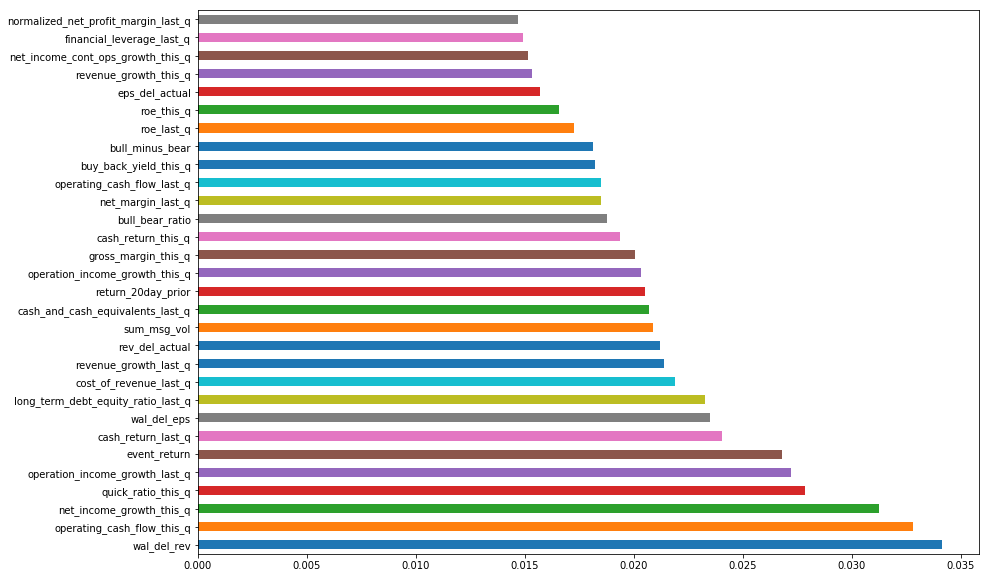

In [199]:
# To see the important features
fig = plt.figure(figsize=(14,10))
(pd.Series(RF_11.feature_importances_, index=features_drift)
   .nlargest(30)
   .plot(kind='barh')) 
plt.show()

As shown above, the most important feature is 'wal_del_rev', the difference in revenue predictions between Wall Street and Estimize. 

__Hyperparameter tuning (including class_weight) using RandomizedSearchCV:__

In [222]:
# Random Forest
RF = RandomForestClassifier()

# 2. Define the parameter grid to be searched from
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Different weights assigned to the imbalanced classes
class_weight = [{-1:0.33, 0:0.33, 1:0.33}, {-1:1, 0:0.5, 1:0.2}, {-1:1, 0:0.7, 1:0.2}, {-1:0.8, 0:0.5, 1:0.2}]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}

# 3. Hyperparameter tuning using RandomizedSearchCV
RF_80_3class_cv = RandomizedSearchCV(RF, random_grid, cv = 4, scoring = 'neg_log_loss', \
                                     random_state = random.seed(1234))
#RF_80_cat_cv = RandomizedSearchCV(RF, random_grid, cv = 4, random_state = 7)
# If not using scoring = 'neg_log_loss', which penalises the confident but wrong predictions, the top 10 stocks ranked
# below would produce only 8% return rather than 13%. 

In [223]:
# Fit the model
RF_80_3class_cv.fit(x_train_drift, y_train_80day_3class)

# Use the optimised parameters to predict
y_pred_80day_3class_RF_cv = RF_80_cat_cv.predict(x_test_drift)

print(confusion_matrix(y_test_80day_3class, y_pred_80day_3class_RF_cv))
print(classification_report(y_test_80day_3class, y_pred_80day_3class_RF_cv))

/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0 24]
 [ 2  0 27]
 [ 8  0 67]]
              precision    recall  f1-score   support

          -1       0.17      0.08      0.11        26
           0       0.00      0.00      0.00        29
           1       0.57      0.89      0.69        75

   micro avg       0.53      0.53      0.53       130
   macro avg       0.24      0.32      0.27       130
weighted avg       0.36      0.53      0.42       130



/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [224]:
RF_80_3class_cv.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'class_weight': {-1: 1, 0: 0.7, 1: 0.2}}

### Get the top 10 stocks with highest probabilities predicted

__SVM__

In [186]:
# Define the default model
svm_0 = SVC(gamma='scale', random_state=7)

# Fit the model
svm_0.fit(x_train_drift, y_train_80day_3class);

# Use the optimised parameters to predict
y_pred_80day_svm0 = svm_0.predict(x_test_drift)

#----------------
# The modified model
svm_1 = SVC(probability=True, gamma='scale', class_weight = {-1:1.1, 0:1, 1:0.7}, random_state=7)

# Fit the model
svm_1.fit(x_train_drift, y_train_80day_3class);

# predict
y_pred_80day_svm1 = svm_1.predict(x_test_drift)

print('The default model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_svm0))
print(classification_report(y_test_80day_3class, y_pred_80day_svm0))

print('\nThe modified model prediction:')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_svm1))
print(classification_report(y_test_80day_3class, y_pred_80day_svm1))
print('class_weight = {-1:1.1, 0:1, 1:0.7}')

The default model prediction:
[[ 0  0 26]
 [ 0  0 29]
 [ 0  0 75]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        26
           0       0.00      0.00      0.00        29
           1       0.58      1.00      0.73        75

   micro avg       0.58      0.58      0.58       130
   macro avg       0.19      0.33      0.24       130
weighted avg       0.33      0.58      0.42       130


The modified model prediction:
[[ 6  0 20]
 [10  0 19]
 [12  0 63]]
              precision    recall  f1-score   support

          -1       0.21      0.23      0.22        26
           0       0.00      0.00      0.00        29
           1       0.62      0.84      0.71        75

   micro avg       0.53      0.53      0.53       130
   macro avg       0.28      0.36      0.31       130
weighted avg       0.40      0.53      0.46       130

class_weight = {-1:1.1, 0:1, 1:0.7}


/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

__AdaBoost__

In [191]:
# Fit the model
Ada_cv.fit(x_train_drift, y_train_80day_3class);

# View the best parameters found
print(Ada_cv.best_params_)

# Use the optimised parameters to predict
y_pred_80day_3class_Ada = Ada_cv.predict(x_test_drift)

print('\n')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_3class_Ada))
print(classification_report(y_test_80day_3class, y_pred_80day_3class_Ada))

{'n_estimators': 100, 'learning_rate': 0.01}


[[ 0  0 26]
 [ 0  0 29]
 [ 0  0 75]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        26
           0       0.00      0.00      0.00        29
           1       0.58      1.00      0.73        75

   micro avg       0.58      0.58      0.58       130
   macro avg       0.19      0.33      0.24       130
weighted avg       0.33      0.58      0.42       130



/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__XGBoost__

In [231]:
# The XGB modeler object
xg = xgb.XGBClassifier(num_class = 3, objective ='multi:softprob', colsample_bytree = 0.3, learning_rate = 0.1,\
                       max_depth = 7, alpha = 10, n_estimators = 500, eval_metric = 'mlogloss',\
                       max_delta_step = 2)

In [47]:
# Fit the model
xg.fit(x_train_drift, y_train_80day_3class);

# predict
y_pred_80day_3class_xg = xg.predict(x_test_drift)

print('\n')
print(confusion_matrix(y_test_80day_3class, y_pred_80day_3class_xg))
print(classification_report(y_test_80day_3class, y_pred_80day_3class_xg))



[[ 1  0  9]
 [ 0  0  9]
 [ 0  0 21]]
              precision    recall  f1-score   support

          -1       1.00      0.10      0.18        10
           0       0.00      0.00      0.00         9
           1       0.54      1.00      0.70        21

   micro avg       0.55      0.55      0.55        40
   macro avg       0.51      0.37      0.29        40
weighted avg       0.53      0.55      0.41        40



/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Qian/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
